In [ ]:
import pandas as pd
dataset = 'boston'
index = 1
data = pd.read_csv('data/' + dataset + '/' + dataset + '_raw.csv', index_col=0)
data

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.422222,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680
1,0.368889,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470
2,0.660000,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466
3,0.631111,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389
4,0.693333,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.386667,0.000633,0.00,0.420455,0.0,0.386831,0.580954,0.681771,0.122671,0.000000,0.164122,0.893617,0.987619,0.219095
502,0.346667,0.000438,0.00,0.420455,0.0,0.386831,0.490324,0.760041,0.105293,0.000000,0.164122,0.893617,1.000000,0.202815
503,0.420000,0.000612,0.00,0.420455,0.0,0.386831,0.654340,0.907312,0.094381,0.000000,0.164122,0.893617,1.000000,0.107892
504,0.377778,0.001161,0.00,0.420455,0.0,0.386831,0.619467,0.889804,0.114514,0.000000,0.164122,0.893617,0.991301,0.131071


In [ ]:
!pip install pyitlib

  Created wheel for pyitlib: filename=pyitlib-0.2.2-py3-none-any.whl size=28500 sha256=08c05f007098a020348cd1a9aff577fee0cbbeee75f81bb583eadc0d55c4bd47
  Stored in directory: /root/.cache/pip/wheels/14/96/d6/86e32d66e5bb0440dc344e75849266b2bf2939520672e33e4e
Successfully built pyitlib


In [ ]:
import glob
import pickle
import IPython as ipy

models = ['mlp', 'gb', 'rf']

results = {}

for model in models:
    runs = []
    results[model] = {}

    for name in glob.glob('results/' + dataset + '/' + model + '*'):
        with open(name, 'rb') as file:
            runs.append(pickle.load(file))

        print(name)
        ipy.display.clear_output(wait=True)

    results[model]['runs'] = runs

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
results

In [ ]:
import numpy as np

for model in models:
    results[model]['rand_run'] = results[model]['runs'][np.random.choice(np.arange(len(results[model]['runs'])))]

In [ ]:
for model in models:
    results[model]['paretos'] = np.hstack([run.population for run in results[model]['runs']])
    results[model]['paretos'] = [individual for individual in results[model]['paretos'] if individual['meta']['test'] > 0]

    print(model + ' solutions: ' + str(len(results[model]['paretos'])))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(palette='rocket')

/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'col

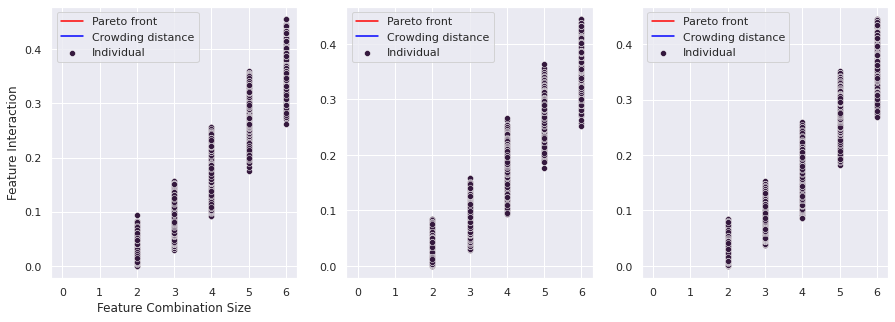

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for model in models:
    sns.scatterplot(x=[individual['meta']['size'] for individual in results[model]['paretos']], y=[individual['meta']['test'] for individual in results[model]['paretos']], ax=axes[models.index(model)], label='Individual')
    sns.lineplot(x=[0], y=[0], ax=axes[models.index(model)], label='Pareto front', c='red')
    sns.lineplot(x=[0], y=[0], ax=axes[models.index(model)], label='Crowding distance', c='blue')
    if models.index(model) == 0:
        axes[models.index(model)].set_xlabel('Feature Combination Size')
    if models.index(model) == 0:
        axes[models.index(model)].set_ylabel('Feature Interaction')
plt.show()
fig.tight_layout()
fig.savefig(dataset + '_pops.pdf', dpi=300)

In [ ]:
for model in models:
    importance = np.zeros(len(data.columns[1:]), dtype=float)
    results[model]['rand_run'].feature_names = data.columns[1:]
    for individual in results[model]['paretos']:
        for j in range(len(individual['data'])):
            if individual['data'][j] == 1:
                try:
                    importance[individual['index'][j]] += individual['meta']['test'] / individual['meta']['size'] / len(results[model]['paretos'])
                except:
                    pass
                
    results[model]['w_interaction'] = importance

In [ ]:
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.neural_network import *

model_type = {'boston': 'r',
              'lemas': 'r',
              'mux': 'c'}

for model in models:
    results[model]['rand_run'].model = {
                      'rfc': RandomForestClassifier(random_state=0),
                      'rfr': RandomForestRegressor(random_state=0),
                      'gbc': GradientBoostingClassifier(random_state=0),
                      'gbr': GradientBoostingRegressor(random_state=0),
                      'mlpc': MLPRegressor(random_state=0, max_iter=1000),
                      'mlpr': MLPRegressor(random_state=0, max_iter=1000, alpha=1)}[model + model_type[dataset]]
    results[model]['rand_run'].model.fit(results[model]['rand_run'].train[:,1:], results[model]['rand_run'].train[:,0])

In [ ]:
from sklearn.inspection import permutation_importance

for model in models:
    results[model]['permutation'] = permutation_importance(results[model]['rand_run'].model, results[model]['rand_run'].test[:,1:], results[model]['rand_run'].test[:,0], n_repeats=100).importances_mean

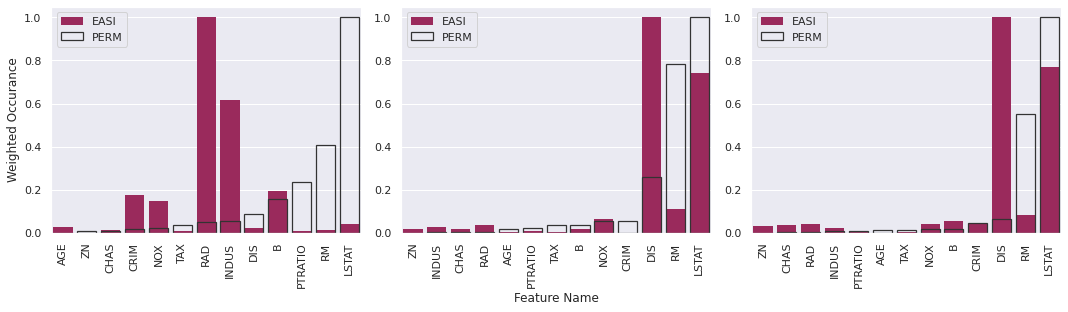

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import minmax_scale

bars = 25

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for model in models:
    perm = minmax_scale(results[model]['permutation'])
    interaction = minmax_scale(results[model]['w_interaction'])
    sns.barplot(x=data.columns[index:][np.argsort(perm)][-bars:], y=interaction[np.argsort(perm)][-bars:], ax=axes[models.index(model)], linewidth=0, edgecolor=(0, 0, 0, 1), palette=[sns.color_palette('rocket')[2]] * len(data.columns[index:]), label='EASI')
    sns.barplot(x=data.columns[index:][np.argsort(perm)][-bars:], y=perm[np.argsort(perm)][-bars:], ax=axes[models.index(model)], linewidth=1.25, facecolor=(1, 1, 1, 0), errcolor="1", edgecolor=".2", label='PERM')
    axes[models.index(model)].set_xticklabels(data.columns[index:][np.argsort(perm)][-bars:], rotation=90)
    if models.index(model) == 0:
        axes[models.index(model)].set_ylabel('Weighted Occurance')
    if models.index(model) == 1:
        axes[models.index(model)].set_xlabel('Feature Name')
    
    axes[models.index(model)].legend()
    try:
        axes[models.index(model)].set_aspect('square')
    except:
        continue

fig.tight_layout()
fig.savefig(dataset + '_occ.pdf', dpi=300)

In [ ]:
for model in models:
    interaction = {}
    results[model]['rand_run'].feature_names = data.columns
    for individual in results[model]['paretos']:
        try:
            interaction[tuple(results[model]['rand_run'].feature_names[index:][np.where(np.array(individual['data']) == 1)])] += individual['meta']['test'] / (2 ** individual['meta']['size'] - individual['meta']['size']) / len(results[model]['paretos'])
        except:
            interaction[tuple(results[model]['rand_run'].feature_names[index:][np.where(np.array(individual['data']) == 1)])] = individual['meta']['test'] / (2 ** individual['meta']['size'] - individual['meta']['size']) / len(results[model]['paretos'])

    results[model]['w_high_order'] = interaction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


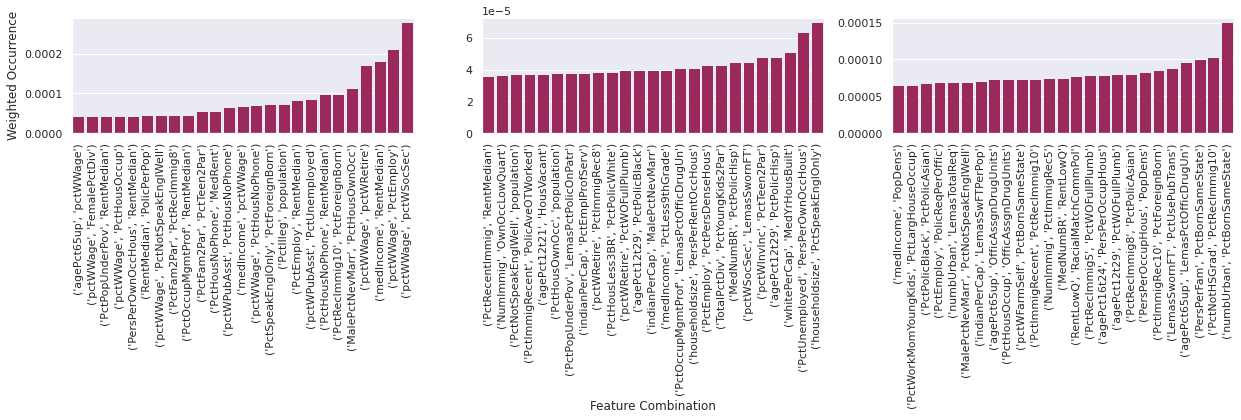

In [ ]:
bars = 25

fig, axes = plt.subplots(1, 3, figsize=(17.5, 6))

for model in models:
    sns.barplot(x=[str(key) for key in sorted(results[model]['w_high_order'], key=results[model]['w_high_order'].get)][-bars:], y=[results[model]['w_high_order'][key] for key in sorted(results[model]['w_high_order'], key=results[model]['w_high_order'].get)][-bars:], ax=axes[models.index(model)], palette=[sns.color_palette('rocket')[2]] * bars, linewidth=0, edgecolor=(0, 0, 0, 1))
    axes[models.index(model)].set_xticklabels([str(key) for key in sorted(results[model]['w_high_order'], key=results[model]['w_high_order'].get)][-bars:], rotation=90)
    if models.index(model) == 0:
        axes[models.index(model)].set_ylabel('Weighted Occurrence')
    if models.index(model) == 1:
        axes[models.index(model)].set_xlabel('Feature Combination')

fig.tight_layout()
fig.savefig(dataset + '_co_occ.pdf', dpi=300)

In [ ]:
for model in models:
    results[model]['w_dependency'] = results[model]['rand_run'].calc_dependancy(results[model]['paretos'], np.zeros(len(data.columns[1:])))

/content/drive/My Drive/summer21/new/src/MRGA.py:374: RuntimeWarning: invalid value encountered in true_divide
  return intersection / total


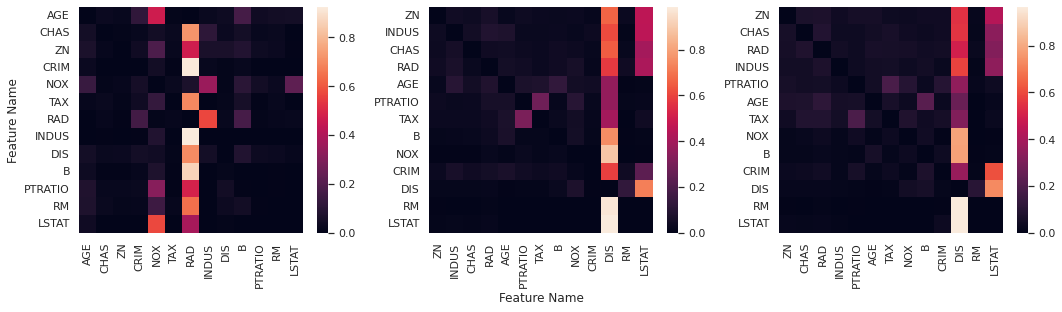

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
scaler = MinMaxScaler()

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for model in models:
    dependency = results[model]['w_dependency']
    sns.heatmap(data=np.nan_to_num(dependency[np.argsort(results[model]['permutation'])][-bars:][:,np.argsort(results[model]['permutation'])[-bars:]]), ax=axes[models.index(model)], cmap='rocket', xticklabels=data.columns[1:][np.argsort(results[model]['permutation'])][-bars:], yticklabels=data.columns[1:][np.argsort(results[model]['permutation'])][-bars:])
    if models.index(model) == 0:
        axes[models.index(model)].set_ylabel('Feature Name')

    if models.index(model) == 1:
        axes[models.index(model)].set_xlabel('Feature Name')

fig.tight_layout()
fig.savefig(dataset + '_depend.pdf', dpi=300)

In [ ]:
from sklearn.neural_network import *
from sklearn.ensemble import *
from sklearn.neighbors import * 
from sklearn.svm import *

dataset = 'lemas'
index = 6
data = pd.read_csv('data/' + dataset + '/' + dataset + '_raw.csv', index_col=0)
train = pd.read_csv('data/'+ dataset + '/' + dataset + '_train.csv', index_col=0)
test = pd.read_csv('data/'+ dataset + '/' + dataset + '_test.csv', index_col=0)
validate = pd.read_csv('data/'+ dataset + '/' + dataset + '_validate.csv', index_col=0)

for model in models:
    results[model]['rand_run'].model.fit(train.values[:,1:], train.values[:,0])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(palette='rocket')

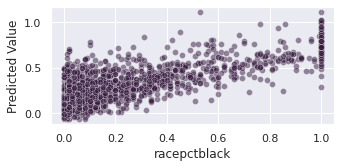

In [ ]:
y_pred = results['mlp']['rand_run'].model.predict(data[data.columns[index:]].values)

fig, ax = plt.subplots(figsize=(5,2.5))
sns.scatterplot(x=data['racepctblack'], y=y_pred, alpha=0.5)
plt.xlabel('racepctblack'), plt.ylabel('Predicted Value')
fig.tight_layout()
fig.savefig('lemas_bias0.pdf', dpi=300)
plt.show()

In [ ]:
grain = 25
bins, dens = np.zeros((grain+1, grain+1)), np.zeros((grain+1, grain+1))
feature_x, feature_y = 'PctSpeakEnglOnly', 'householdsize'
y_pred = results['gb']['rand_run'].model.predict(data[data.columns[index:]].values)

for i in range(len(y_pred)):
    bin_x, bin_y = int(data[feature_x][i] * grain), int(data[feature_y][i] * grain)
    bins[bin_x, bin_y] += y_pred[i]
    dens[bin_x, bin_y] += 1                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


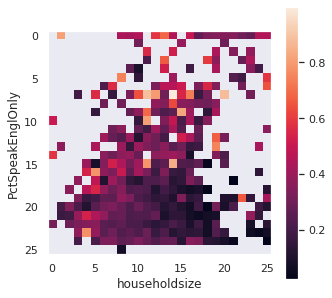

In [ ]:
import matplotlib.patches as patches

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

pos = axes.imshow(bins/dens, cmap='rocket')
axes.imshow(bins/dens, alpha=dens, cmap='rocket')
plt.xlabel(feature_y), plt.ylabel(feature_x)
plt.grid(False)
plt.colorbar(pos)
fig.savefig('lemas_bias1.pdf', dpi=300)
plt.show()

In [ ]:
high = data[data[feature_x] >= 0.8]
high = high[high[feature_x] <= 1]
high = high[high[feature_y] >= 0.2]
high = high[high[feature_y] <= 0.8]
high.shape

(1279, 128)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


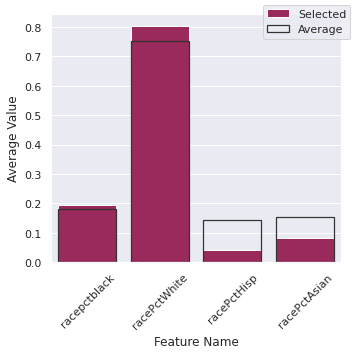

In [ ]:
racial = ['racepctblack', 'racePctWhite', 'racePctHisp', 'racePctAsian']

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(high[racial].columns.values, high[racial].mean().values, ax=ax, palette=[sns.color_palette('rocket')[2]] * len(racial), label='Selected')
sns.barplot(high[racial].columns.values, data[racial].mean().values, ax=ax, linewidth=1.25, facecolor=(1, 1, 1, 0), errcolor="1", edgecolor=".2", label='Average')
plt.xlabel('Feature Name'), plt.ylabel('Average Value')
ax.set_xticklabels(racial, rotation=45)
fig.legend()
fig.tight_layout()
fig.savefig('lemas_dem1.pdf', dpi=300)
plt.show()

In [ ]:
grain = 25
bins, dens = np.zeros((grain+1, grain+1)), np.zeros((grain+1, grain+1))
feature_x, feature_y = 'numbUrban', 'PctBornSameState'
y_pred = results['rf']['rand_run'].model.predict(data[data.columns[index:]].values)

for i in range(len(y_pred)):
    bin_x, bin_y = int(data[feature_x][i] * grain), int(data[feature_y][i] * grain)
    bins[bin_x, bin_y] += y_pred[i]
    dens[bin_x, bin_y] += 1                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


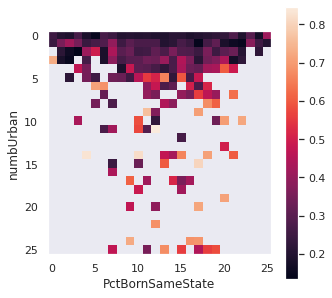

In [ ]:
import matplotlib.patches as patches

fig, axes = plt.subplots(figsize=(5, 5))

pos = axes.imshow(bins/dens, cmap='rocket')
axes.imshow(bins/dens, alpha=dens, cmap='rocket')
plt.xlabel(feature_y), plt.ylabel(feature_x)
plt.grid(False)
plt.colorbar(pos)
fig.savefig('lemas_bias2.pdf', dpi=300)
plt.show()

In [ ]:
high = data[data[feature_x] >= 0]
high = high[high[feature_x] <= 0.1]
high = high[high[feature_y] >= 0]
high = high[high[feature_y] <= 1]
high.shape

(1708, 128)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


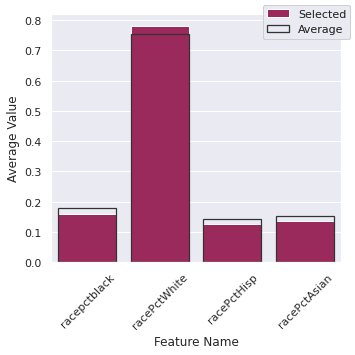

In [ ]:
racial = ['racepctblack', 'racePctWhite', 'racePctHisp', 'racePctAsian']

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(high[racial].columns.values, high[racial].mean().values, ax=ax, palette=[sns.color_palette('rocket')[2]] * len(racial), label='Selected')
sns.barplot(high[racial].columns.values, data[racial].mean().values, ax=ax, linewidth=1.25, facecolor=(1, 1, 1, 0), errcolor="1", edgecolor=".2", label='Average')
plt.xlabel('Feature Name'), plt.ylabel('Average Value')
ax.set_xticklabels(racial, rotation=45)
fig.legend()
fig.tight_layout()
fig.savefig('lemas_dem2.pdf', dpi=300)
fig.legend()
plt.show()

In [ ]:
from sklearn.neural_network import *
from sklearn.ensemble import *
from sklearn.neighbors import * 
from sklearn.svm import *

dataset = 'boston'
index = 1
data = pd.read_csv('data/'+ dataset + '/' + dataset + '_raw.csv', index_col=0)
train = pd.read_csv('data/'+ dataset + '/' + dataset + '_train.csv', index_col=0)
test = pd.read_csv('data/'+ dataset + '/' + dataset + '_test.csv', index_col=0)
validate = pd.read_csv('data/'+ dataset + '/' + dataset + '_validate.csv', index_col=0)

for model in models:
    results[model]['rand_run'].model.fit(train.values[:,1:], train.values[:,0])

In [ ]:
grain = 25
bins, dens = np.zeros((grain+1, grain+1)), np.zeros((grain+1, grain+1))
feature_x, feature_y = 'B', 'RAD'
y_pred = results['mlp']['rand_run'].model.predict(data[data.columns[index:]].values)

for i in range(len(y_pred)):
    bin_x, bin_y = int(data[feature_x][i] * grain), int(data[feature_y][i] * grain)
    bins[bin_x, bin_y] += y_pred[i]
    dens[bin_x, bin_y] += 1      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


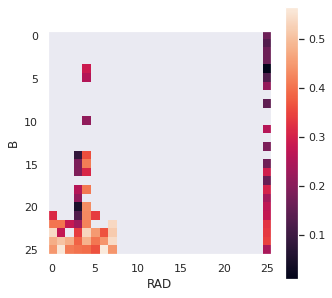

In [ ]:
import matplotlib.patches as patches

fig, axes = plt.subplots(figsize=(5, 5))

pos = axes.imshow(bins/dens, cmap='rocket')
axes.imshow(bins/dens, alpha=dens, cmap='rocket')
plt.xlabel(feature_y), plt.ylabel(feature_x)
plt.grid(False)
plt.colorbar(pos)
fig.savefig('boston_bias0.pdf', dpi=300)
plt.show()

In [ ]:
high = data[data[feature_x] >= 0]
high = high[high[feature_x] <= 0.5]
high = high[high[feature_y] >= 0.8]
high = high[high[feature_y] <= 1]
high.shape

(34, 14)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


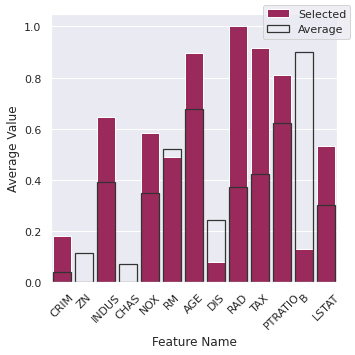

In [ ]:
racial = data.columns[1:]

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(high[racial].columns.values, high[racial].mean().values, ax=ax, palette=[sns.color_palette('rocket')[2]] * len(racial), label='Selected')
sns.barplot(high[racial].columns.values, data[racial].mean().values, ax=ax, linewidth=1.25, facecolor=(1, 1, 1, 0), errcolor="1", edgecolor=".2", label='Average')
plt.xlabel('Feature Name'), plt.ylabel('Average Value')
ax.set_xticklabels(racial, rotation=45)
fig.legend()
fig.tight_layout()
fig.savefig('boston_dem0.pdf', dpi=300)
plt.show()

In [ ]:
grain = 25
bins, dens = np.zeros((grain+1, grain+1)), np.zeros((grain+1, grain+1))
feature_x, feature_y = 'B', 'DIS'
y_pred = results['gb']['rand_run'].model.predict(data[data.columns[index:]].values)

for i in range(len(y_pred)):
    bin_x, bin_y = int(data[feature_x][i] * grain), int(data[feature_y][i] * grain)
    bins[bin_x, bin_y] += y_pred[i]
    dens[bin_x, bin_y] += 1    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


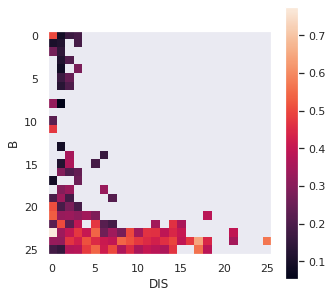

In [ ]:
import matplotlib.patches as patches

fig, axes = plt.subplots(figsize=(5, 5))

pos = axes.imshow(bins/dens, cmap='rocket')
axes.imshow(bins/dens, alpha=dens, cmap='rocket')
plt.xlabel(feature_y), plt.ylabel(feature_x)
plt.grid(False)
plt.colorbar(pos)
fig.savefig('boston_bias1.pdf', dpi=300)
plt.show()

In [ ]:
high = data[data[feature_x] >= 0]
high = high[high[feature_x] <= 0.8]
high = high[high[feature_y] >= 0]
high = high[high[feature_y] <= 0.2]
high.shape

(55, 14)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


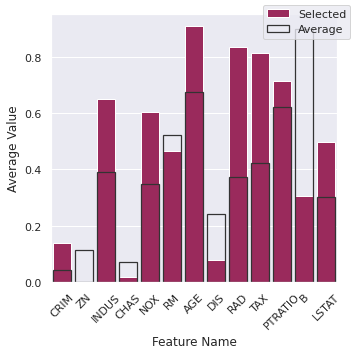

In [ ]:
racial = data.columns[1:]

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(high[racial].columns.values, high[racial].mean().values, ax=ax, palette=[sns.color_palette('rocket')[2]] * len(racial), label='Selected')
sns.barplot(high[racial].columns.values, data[racial].mean().values, ax=ax, linewidth=1.25, facecolor=(1, 1, 1, 0), errcolor="1", edgecolor=".2", label='Average')
plt.xlabel('Feature Name'), plt.ylabel('Average Value')
ax.set_xticklabels(racial, rotation=45)
fig.legend()
fig.tight_layout()
fig.savefig('boston_dem1.pdf', dpi=300)
plt.show()

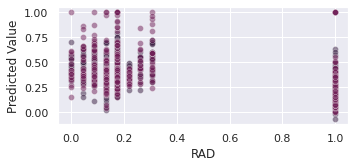

In [ ]:
y_pred = results['mlp']['rand_run'].model.predict(data[data.columns[index:]].values)
y = data['MEDV']

fig, ax = plt.subplots(figsize=(5,2.5))
sns.scatterplot(x=data['RAD'], y=y_pred, alpha=0.5)
sns.scatterplot(x=data['RAD'], y=y, alpha=0.5)

plt.xlabel('RAD'), plt.ylabel('Predicted Value')
fig.tight_layout()
plt.show()